In [1]:
from scipy.stats import spearmanr, pearsonr

from bertscore import BERTScore
from conventional_metrics import BLEU, METEOR
from scm import SCM, ContextualSCM
from wmd import WMD, ContextualWMD
from common import Evaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

if not (Path('embeddings')/'cc.en.300.bin').exists():
    %mkdir -p embeddings
    ! wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -O embeddings/cc.en.300.bin.gz
    ! gzip -d embeddings/cc.en.300.bin.gz

### Mutual correlations of metrics

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xnovot32/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'l

Evaluating lang pair zh-en


WMD_contextual: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46837/46837 [32:07<00:00, 24.30it/s]
BERTScore: 1464it [05:05,  4.79it/s]                                                                                                                                                                              
WMD: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46837/46837 [04:47<00:00, 163.11it/s]


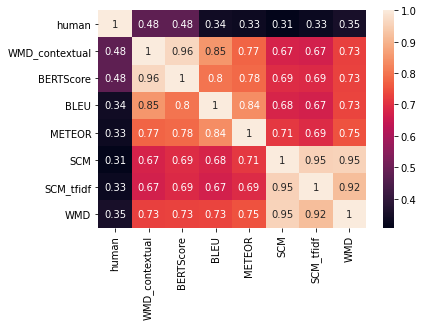

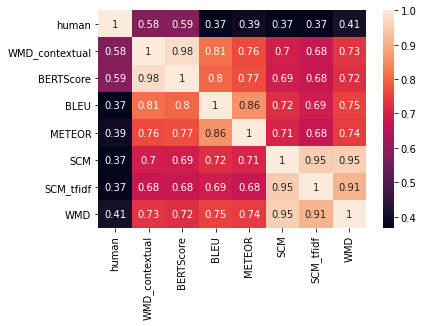

CPU times: user 7h 55min 18s, sys: 12h 43min 27s, total: 20h 38min 45s
Wall time: 1h 39min 21s


In [3]:
%%time

metrics = [
    ContextualWMD(tgt_lang="en"),
    # ContextualSCM(tgt_lang="en"),
    BERTScore(tgt_lang="en"),
    BLEU(),
    METEOR(),
    SCM(tgt_lang="en", use_tfidf=False),
    SCM(tgt_lang="en", use_tfidf=True),
    WMD(tgt_lang="en"),
]

correlations = {m.label: {} for m in metrics}
correlations["human"] = {}

correlations_p = correlations.copy()
reports = []
langs = Evaluator.langs_qm

selected_lang_pairs = [pair for pair in langs if pair.split("-")[-1] == "en"]

for lang_pair in selected_lang_pairs:
    print("Evaluating lang pair %s" % lang_pair)
    evaluator = Evaluator("data_dir", lang_pair, metrics, judgements_type="MQM", firstn=None)
    report = evaluator.evaluate()
    reports.append(report)
 
    human_judgements = report["human"]
#     for metric_label, vals in report.items():
#         correlations[metric_label][lang_pair] = spearmanr(vals, human_judgements).correlation
#         correlations_p[metric_label][lang_pair] = pearsonr(vals, human_judgements)[0]

    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="pearson").applymap(abs), annot=True)
    plt.show()
    sns.heatmap(pd.DataFrame(report).applymap(float).corr(method="spearman").applymap(abs), annot=True)
    plt.show()

# corrs_df = pd.DataFrame(correlations)

## Correlations of metrics to Expert Scalar Quality Metrics (eSQM) per language

<AxesSubplot:>

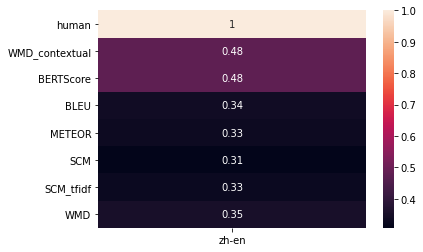

In [4]:
# Pearson
corrs_p = pd.concat([pd.DataFrame(report).corr(method="pearson").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)

<AxesSubplot:>

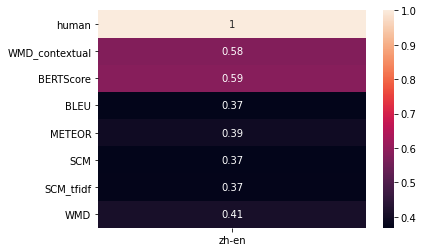

In [5]:
# Spearman
corrs_p = pd.concat([pd.DataFrame(report).corr(method="spearman").abs()["human"] for report in reports], axis=1)
corrs_p.columns = selected_lang_pairs
sns.heatmap(pd.DataFrame(corrs_p), annot=True)